In [1]:
from reinforce import ReinforceAgent, Categorical2D
from visualisation import draw_qap, draw_assignment_graph
from qap import GraphAssignmentProblem, AssignmentGraph
from torch_geometric.utils import from_networkx
import taskgenerators
import torch
from evaluate import random_assignment
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open("testgraph.qap", "r") as f:
    qap = GraphAssignmentProblem.from_qaplib_string(f.read())

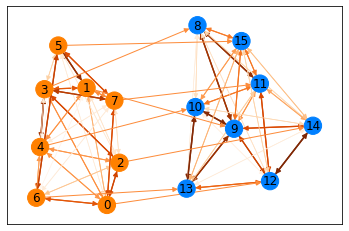

In [3]:
draw_qap(qap, random_assignment(qap))

In [4]:
agent = ReinforceAgent()
#agent.load_checkpoint("../runs/reinforce_transformer_random_graphs_1/checkpoint_end.pth")

In [5]:
data = agent.transform_initial_graph(qap.graph_source)
print(data)

Data(x=[8, 32], edge_index=[2, 56], edge_attr=[56, 32])


In [6]:
data.edge_attr

tensor([[ 1.3395e-02,  6.9453e-02,  3.0383e-02,  ...,  4.4208e-03,
          8.6274e-02,  4.6839e-02],
        [ 2.2225e-02,  7.1649e-02,  2.3863e-02,  ..., -8.4298e-03,
          1.0287e-01,  6.6867e-02],
        [ 1.6390e-02,  7.0350e-02,  2.8228e-02,  ...,  7.8641e-05,
          9.1695e-02,  5.3940e-02],
        ...,
        [ 7.5645e-03,  6.7081e-02,  3.4096e-02,  ...,  1.2880e-02,
          7.5892e-02,  3.1473e-02],
        [ 2.1417e-02,  7.1499e-02,  2.4477e-02,  ..., -7.2362e-03,
          1.0127e-01,  6.5134e-02],
        [ 7.5685e-03,  6.7083e-02,  3.4094e-02,  ...,  1.2875e-02,
          7.5898e-02,  3.1484e-02]], grad_fn=<IndexBackward0>)

In [7]:
agent.solve_and_learn(qap)

(13.92417955238684, array([6., 2., 4., 1., 3., 5., 0., 7.]))

In [8]:
for param in agent.networks.parameters():
    print(torch.norm(param.grad))

tensor(0.0088)
tensor(0.0022)
tensor(0.0447)
tensor(0.0024)
tensor(0.0442)
tensor(0.0022)
tensor(0.0424)
tensor(0.0033)
tensor(0.0464)
tensor(0.0032)
tensor(0.0494)
tensor(0.0032)
tensor(0.0038)
tensor(0.0004)
tensor(0.0047)
tensor(0.0004)
tensor(0.0046)
tensor(0.0005)
tensor(0.0052)
tensor(0.0008)
tensor(1.6121e-05)
tensor(1.1537e-10)
tensor(9.4519e-06)
tensor(1.6743e-05)
tensor(0.0010)
tensor(0.0026)
tensor(0.0331)
tensor(0.0032)
tensor(0.0026)
tensor(3.1523e-06)
tensor(3.1022e-11)
tensor(5.8304e-06)
tensor(4.5241e-06)
tensor(0.0040)
tensor(0.0024)
tensor(0.0311)
tensor(0.0198)
tensor(0.0024)
tensor(0.0827)
tensor(0.0011)
tensor(0.0454)
tensor(0.0022)
tensor(0.0456)
tensor(0.0028)
tensor(0.0526)
tensor(0.0022)
tensor(0.0534)
tensor(2.2650e-06)
tensor(0.0001)
tensor(0.0002)
tensor(0.0002)
tensor(0.0003)
tensor(0.0004)
tensor(0.0006)
tensor(0.0006)
tensor(0.0009)


In [9]:
data_a = agent.transform_initial_graph(qap.graph_source)
data_b = agent.transform_initial_graph(qap.graph_target)

In [10]:
embeddings_a = agent.messaging_net(data_a.x, data_a.edge_index, data_a.edge_attr)
embeddings_b = agent.messaging_net(data_b.x, data_b.edge_index, data_b.edge_attr)

In [11]:
probabilities = agent.compute_link_probabilities(embeddings_a, embeddings_b)
print(probabilities)

tensor([[[0.0133],
         [0.0141],
         [0.0134],
         [0.0136],
         [0.0135],
         [0.0134],
         [0.0133],
         [0.0133]],

        [[0.0131],
         [0.0139],
         [0.0133],
         [0.0135],
         [0.0133],
         [0.0132],
         [0.0131],
         [0.0132]],

        [[0.0130],
         [0.0138],
         [0.0131],
         [0.0133],
         [0.0132],
         [0.0131],
         [0.0130],
         [0.0130]],

        [[0.0134],
         [0.0142],
         [0.0135],
         [0.0137],
         [0.0136],
         [0.0135],
         [0.0134],
         [0.0134]],

        [[0.0130],
         [0.0139],
         [0.0132],
         [0.0134],
         [0.0133],
         [0.0132],
         [0.0130],
         [0.0131]],

        [[0.0130],
         [0.0139],
         [0.0132],
         [0.0134],
         [0.0132],
         [0.0131],
         [0.0130],
         [0.0131]],

        [[0.0129],
         [0.0137],
         [0.0131],
         [0.0133],


In [12]:
policy = Categorical2D(probabilities)

In [13]:
policy.distribution.probs

tensor([0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156], grad_fn=<SoftmaxBackward0>)

In [14]:
embeddings_a

tensor([[-4.6365e-03, -6.8652e-02,  1.5002e-01, -8.9353e-02,  9.6716e-02,
          1.6055e-01, -1.7368e-03,  1.6478e-01, -4.1024e-02,  1.0321e-01,
          4.8881e-02, -4.3106e-02,  8.2500e-02,  1.2401e-01, -1.6088e-01,
          6.8868e-02,  5.9631e-02,  3.5896e-02, -5.2381e-02,  5.4795e-02,
         -2.1070e-01,  2.6659e-01,  2.3069e-01, -9.1798e-02, -1.1471e-01,
         -2.6292e-02, -4.9040e-02,  6.3425e-02, -6.8722e-02,  7.3723e-02,
          1.1888e-01,  2.2020e-01],
        [-3.6845e-03, -6.9147e-02,  1.4948e-01, -9.0210e-02,  9.8056e-02,
          1.6040e-01, -1.4997e-04,  1.6346e-01, -4.1191e-02,  1.0176e-01,
          4.9455e-02, -4.2636e-02,  8.2226e-02,  1.2485e-01, -1.5992e-01,
          7.0085e-02,  5.8424e-02,  3.5750e-02, -5.1435e-02,  5.4673e-02,
         -2.1056e-01,  2.6490e-01,  2.3001e-01, -9.1897e-02, -1.1380e-01,
         -2.5656e-02, -4.8723e-02,  6.3819e-02, -6.9916e-02,  7.3152e-02,
          1.1860e-01,  2.1903e-01],
        [-2.8770e-03, -6.9509e-02,  1.49

In [15]:
embeddings_b

tensor([[-0.0033, -0.0693,  0.1494, -0.0907,  0.0985,  0.1603,  0.0007,  0.1631,
         -0.0415,  0.1010,  0.0501, -0.0420,  0.0822,  0.1253, -0.1593,  0.0703,
          0.0579,  0.0352, -0.0511,  0.0544, -0.2107,  0.2646,  0.2298, -0.0918,
         -0.1141, -0.0255, -0.0486,  0.0638, -0.0705,  0.0727,  0.1187,  0.2189],
        [-0.0077, -0.0673,  0.1518, -0.0870,  0.0926,  0.1609, -0.0066,  0.1685,
         -0.0409,  0.1076,  0.0476, -0.0437,  0.0835,  0.1216, -0.1634,  0.0649,
          0.0632,  0.0362, -0.0555,  0.0549, -0.2110,  0.2718,  0.2331, -0.0912,
         -0.1183, -0.0284, -0.0499,  0.0622, -0.0651,  0.0750,  0.1201,  0.2240],
        [-0.0040, -0.0690,  0.1498, -0.0901,  0.0975,  0.1604, -0.0006,  0.1640,
         -0.0414,  0.1021,  0.0497, -0.0422,  0.0824,  0.1247, -0.1600,  0.0694,
          0.0587,  0.0354, -0.0518,  0.0545, -0.2107,  0.2658,  0.2304, -0.0917,
         -0.1148, -0.0260, -0.0488,  0.0636, -0.0696,  0.0731,  0.1189,  0.2197],
        [-0.0051, -0.0684

<IPython.core.display.Javascript object>


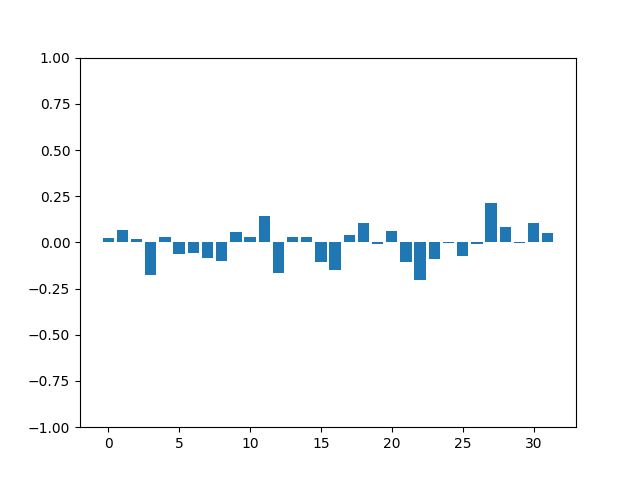

interactive(children=(FloatSlider(value=0.5, description='x', max=1.0), FloatSlider(value=0.5, description='y'…

In [21]:
%matplotlib notebook
from ipywidgets import interact

fig,ax = plt.subplots()

@interact(x=(0.,1.), y=(0.,1.))
def show_edge_embedding(x, y):
    with torch.no_grad():
        embedding = agent.edge_embedding_net(torch.tensor([x,y]))
        ax.clear()
        ax.set_ylim(-1,1)
        ax.bar(range(len(embedding)), embedding)
        
fig.show()

In [17]:
def print_parameter_gradients(x):
    agent.optimizer.zero_grad()
    x.backward(retain_graph=True)
    for param in agent.networks.parameters():
        print(torch.norm(param.grad))

In [18]:
print_parameter_gradients(embeddings_a[3,1])

tensor(0.0079)
tensor(0.0105)
tensor(0.0747)
tensor(0.0206)
tensor(0.0635)
tensor(0.0346)
tensor(0.0872)
tensor(0.0700)
tensor(0.1352)
tensor(0.1626)
tensor(0.2425)
tensor(0.3020)
tensor(0.0255)
tensor(0.0467)
tensor(0.0872)
tensor(0.0894)
tensor(0.1212)
tensor(0.1485)
tensor(0.2197)
tensor(0.3088)
tensor(1.0313e-08)
tensor(1.5897e-12)
tensor(6.5202e-07)
tensor(1.1162e-06)
tensor(0.2762)
tensor(0.4733)
tensor(0.2580)
tensor(0.2763)
tensor(0.4733)
tensor(2.9570e-07)
tensor(2.7765e-12)
tensor(7.9578e-06)
tensor(6.5329e-06)
tensor(0.4038)
tensor(0.3317)
tensor(0.1807)
tensor(0.4041)
tensor(0.3317)
tensor(1.7463)
tensor(0.9316)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
